# UBC Scientific Software Seminar

October 27, 2017

* New York City Taxi Trip Duration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import the data

Let's begin by importing the data. We know that the columns at index 2 and 3 are dates and so we use the datetime parser when reading the .csv file.

In [2]:
trips = pd.read_csv("train.csv",parse_dates=[2,3],usecols=[0,1,2,3,5,6,7,8,10])

In [3]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,-73.982155,40.767937,-73.964630,40.765602,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,-73.980415,40.738564,-73.999481,40.731152,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,-73.979027,40.763939,-74.005333,40.710087,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,-74.010040,40.719971,-74.012268,40.706718,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,-73.973053,40.793209,-73.972923,40.782520,435


### Extract date features

In [4]:
trips['hour'] = trips['pickup_datetime'].dt.hour
trips['dayofweek'] = trips['pickup_datetime'].dt.weekday_name

### Remove outliers

In [5]:
outliers = trips[trips['trip_duration'] > 7000].copy()
trips = trips.drop(outliers.index)

### Models

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(trips, trips['trip_duration'], test_size=0.20)

In [45]:
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
hours = list(range(0,24))
coordinates = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

In [46]:
from sklearn.neighbors import KNeighborsRegressor as KNR

In [47]:
clfs = {day:{} for day in days}

In [48]:
for day in days:
    for hour in hours:
        clf = KNR(n_neighbors=25,weights='distance')
        rows = (X_train['hour'] == hour) & (X_train['dayofweek'] == day)
        X = X_train.loc[rows,coordinates]
        y = y_train.loc[rows]
        clf.fit(X,y)
        clfs[day][hour] = clf

In [49]:
submission = pd.DataFrame(columns=['id','trip_duration'])
for day in days:
    for hour in hours:
        rows = (X_test['hour'] == hour) & (X_test['dayofweek'] == day)
        X_test_1 = X_test.loc[rows,coordinates]
        id_test = X_test.loc[rows,'id']
        y_test_1 = clfs[day][hour].predict(X_test_1)
        submission = submission.append(pd.DataFrame({'id': id_test, 'trip_duration': y_test_1}))

In [50]:
submission = submission.merge(X_test[['id','trip_duration']],left_on='id',right_on='id',how='outer')

In [51]:
submission.columns = ['id','p','a']

In [52]:
def score(submission):
    return np.sqrt(((np.log(submission['p']+1) - np.log(submission['a']+1))**2).sum()/len(submission))

In [53]:
score(submission)

0.42804883988057268

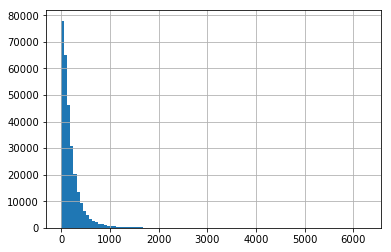

In [17]:
np.abs(submission['p'] - submission['a']).sort_values().hist(bins=100)

### Submission

In [39]:
clfs = {day:{} for day in days}

In [40]:
for day in days:
    for hour in hours:
        clf = KNR(n_neighbors=8,weights='distance')
        rows = (trips['hour'] == hour) & (trips['dayofweek'] == day)
        X = trips.loc[rows,coordinates]
        y = trips.loc[rows,'trip_duration']
        clf.fit(X,y)
        clfs[day][hour] = clf

In [30]:
test = pd.read_csv('test.csv',parse_dates=[2])

In [31]:
test['hour'] = test['pickup_datetime'].dt.hour
test['dayofweek'] = test['pickup_datetime'].dt.weekday_name

In [41]:
submission = pd.DataFrame(columns=['id','trip_duration'])
for day in days:
    for hour in hours:
        rows = (test['hour'] == hour) & (test['dayofweek'] == day)
        X_test = test.loc[rows,coordinates]
        id_test = test.loc[rows,'id']
        y_test = clfs[day][hour].predict(X_test)
        submission = submission.append(pd.DataFrame({'id': id_test, 'trip_duration': y_test}))

In [42]:
submission.to_csv('submission.csv',index=False)

In [ ]:
submission.shape

In [55]:
trips['distance'] = np.abs(trips['pickup_longitude'] - trips['dropoff_longitude']) + np.abs(trips['pickup_latitude'] - trips['dropoff_latitude'])

In [57]:
trips = pd.concat([trips,pd.get_dummies(trips['dayofweek'])],axis=1)

In [78]:
X = trips[['hour','distance'] + days]

In [79]:
y = trips['trip_duration']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [88]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [80]:
reg = RFR()

In [81]:
reg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [82]:
test['distance'] = np.abs(test['pickup_longitude'] - test['dropoff_longitude']) + np.abs(test['pickup_latitude'] - 
                                                                                         test['dropoff_latitude'])

In [83]:
test = pd.concat([test,pd.get_dummies(test['dayofweek'])],axis=1)

In [84]:
X_test = test[['hour','distance'] + days]
y_submit = reg.predict(X_test)

In [85]:
submission = pd.DataFrame({'id': test['id'], 'trip_duration': y_submit})

In [86]:
submission.to_csv('submit.csv',index=False)

In [91]:
0.46**2

0.2116